## Figure 3: 

##### This notebook reproduces the analysis used to generate Figure 3. It uses the equations presented in Section 2.1 of Maryann et al. (2025) for a sample of 20 asteroids. The astrometric data for the asteroids span over a single night, and is taken from the NASA JPL Horizons System. The distances range from approximately 0.05 au to 2.4 au, with 2024 ON representing the nearest object and Ceres the most distant. All steps, parameters, and fitting procedures follow the methodology described in Section 2.3 of the manuscript.

##### We use both the linear model in Equation 1 as well as the quadratic model in Equation 5 to evaluate how each fit function responses to asteroids observed over a short observational arcs. From these results, we will be able to determine which formulation is necessary for accurate analysis for asteroids with limited acrs.

##### Step 1: Here we import all the packages used throughout the notebook:

In [10]:
# For numerical arrays and dataframes.
import numpy as np
import pandas as pd

# For handling plotting and axis formatting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# For custom subplot layouts
from matplotlib.gridspec import GridSpec

# Tools for fitting functions to data
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit

# For file handling and regular expressions
import re
import os
from pathlib import Path

# Access to trigonometric functions and constants.
import math

# For custom legends
from matplotlib.lines import Line2D

# For generating random numbers
import random

##### Step 2: Reading and Extracting the raw data of the 20 asteroids from the NASA JPL Horizon System

In [11]:
# txt_files_folder: where the Horizons .txt files are stored
# csv_output_folder: where the converted .csv files will be saved
txt_files_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 3'
csv_output_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files'

# os.makedirs(): creates the above folder if it does not exist.
if not os.path.exists(csv_output_folder):
    os.makedirs(csv_output_folder)
    print(f"Created output folder: {csv_output_folder}")

# In the DataFrame's list, the following are the column headers. The blanks denoted by '' correspond to columns that are not required in the analysis. 
# Date__(UT)__HR:MN = the time and day for each observation. 
# R.A._(ICRF), DEC__(ICRF) = The RA and DEC data of each observation in decimal format
# delta = the distance to the asteroid at each observation in astronomical units (au). We use Horizons distance to verify the measured topocentric parallax distance in step 5 so as to confirm the measured difference from the true distance. 
# deldot = the range rate (km/sec). We do not use this column in our analysis, but FYI, a positive deldot indicates that an object is moving away from the observer, and a negative deldot indicates that an object is moving towards the observer.
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', 'deldot', '']

# ------- We convert the document from a .txt file to a .csv file in the following steps, and then use a pandas.DataFrame to create in the new file, the same column names as seen in the orignal file.

# Loops through every item in the folder to identify relevant files.
for file_name in os.listdir(txt_files_folder):

    # The file to process must have an extension of .txt
    if file_name.endswith('.txt'):
        file_path = os.path.join(txt_files_folder, file_name)

        # We only want to extract the code between “SOE” (Start of Ephemeris) and “EOE” (End of Ephemeris), since they contain the ephemeris data. 
        start_marker = "$$SOE"
        end_marker = "$$EOE"

        # data_lines: collects the data --> row by row between SOE and EOE.
        data_lines = []
        try:
            
            # open: opens the file in read mode using 'r'. 
            # with: ensures that the file is closed properly after read.
            with open(file_path, 'r') as file:

                # is_data: A Boolean flag indicating that if a row of data is under analysis and between SOE and EOE, then the data needs to be stored. 
                is_data = False

                # Iterates through every line
                for line in file:

                    # When a row of line contains SOE, then start marker, then is_data is set to True, and beyond this line data will be captured.
                    if start_marker in line:
                        is_data = True

                    # When a row of line contains EOE, the end marker, then is_data is set to False, and beyond this line data will not be captured.
                    elif end_marker in line:
                        is_data = False
                   
                    # In the case if neither markers are not found, and is_data is set at true, this means that data capturing is still on-going, and hasn't reached EOE. 
                    elif is_data:

                        # .strip(): removes whitespace and sends lines to data_lines.
                        data_lines.append(line.strip())

            # Each line of ephemeris data that is captured is split at the commas to form string values so that they are in the form of rows and columns (lists of lists) for the .csv file. 
            data = [line.split(",") for line in data_lines]

            # max_columns: searches for the longest row and length.
            max_columns = max(len(row) for row in data)

            # Short rows are padded with empty strings at locations that do not have data, so as to represent the same length as the longest row. This is to make sure that the DataFrame is being created without misaligned columns.       
            data = [row + [''] * (max_columns - len(row)) for row in data]

           # Create a DataFrame and assign the appropriate column headers.
            df = pd.DataFrame(data, columns=columns[:max_columns])

            # os.path.basename(file_path): extracts the filename
            # os.path.splitext(...)[0]: removes the .txt file extension so that a new .csv extension can be added
            base_name = os.path.splitext(file_name)[0]
            csv_file_path = os.path.join(csv_output_folder, f'{base_name}.csv')
            df.to_csv(csv_file_path, index=False)
            print(f"CSV file saved: {csv_file_path}")
            
        # Error handling: gives notification if a file is not found or if there are unexpected errors.
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 YR4.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2020 UF7.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/4953.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2022 QV1.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 ON.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 RN45.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2022 PH1.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2022 YK6.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 SJ.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 SR4.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 RJ16.csv
CSV file saved: /hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/2024 SS.c

##### Step 3: Verify that the columns with data that will be analyzed have been properly copied to the new .csv file. 

In [12]:
def read_horizons_file(file_path):
    try:
        # Read the .csv file
        data = pd.read_csv(file_path)

        # Shorten the original names of the columns
        column_mapping = {
            'Date__(UT)__HR:MN': 'JDUT',
            ' R.A._(ICRF)': 'RA_ICRF',
            'DEC__(ICRF)': 'DEC_ICRF',
            'delta': 'delta'}
        data = data.rename(columns=column_mapping)

        # The four columns required for curve fitting.
        required_columns = ['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta']

        # Check that all required columns are present in the DataFrame.
        # If any are missing, raise an error to alert the user.
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"Missing one or more required columns in {file_path}")

        # Return a DataFrame containing only the needed columns in the correct order.
        return data[required_columns]

    except Exception as e:
        # If anything goes wrong, print an error message including the filename.
        print(f"Error reading {file_path}: {e}")

        # Return an empty DataFrame with the correct column structure
        return pd.DataFrame(columns=['JDUT', 'RA_ICRF', 'DEC_ICRF', 'delta'])

##### Step 4: Addition of a randomly generated 20 milliarcseconds (mas) Gaussian noise to each observation in the RA and DEC. 

In [13]:
# input_file: The original file path with RA and DEC.
# output_file: The new file path with noise added in the RA and DEC. 
input_folder  = Path("/hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files")
output_folder = input_folder / "with_uncertainties"

# The columns that need noise addition in the original file.  
output_folder.mkdir(parents=True, exist_ok=True)
RA_COL  = " R.A._(ICRF)"      
DEC_COL = "DEC__(ICRF)"

# Horizons does not provide measurement uncertainties in RA and DEC. So, we randomly add 20 mas of noise to mimic real astrometric errors.
# 20 mas converted to arcseconds. 1 mas = 0.001 arcsec and 20 mas = 0.020 arcsec
# The noise is Gaussian-distributed, consistent with typical astrometric uncertainties.
# 20 mas was chosen since it is a realistic uncertainty approximation based on typical CCD astrometric performance.
SIGMA_ARCSEC = 0.020      

# converting arcseconds into degrees because RA/DEC in the original Horizons file is in degrees (1 degree = 3600"). 
SIGMA_DEG    = SIGMA_ARCSEC / 3600.0  

# A random generator. seed=42 ensures reproducible noise, where every run of the code ensures that the noise to the observations stays the same. 
rng = np.random.default_rng(seed=42)

for csv_file in input_folder.glob("*.csv"):
    # Reads the CSV into a DataFrame, where each row is an observation.
    df = pd.read_csv(csv_file)

# A safety check: If RA or DEC columns are missing, stop the code and show an error.    
    if RA_COL not in df.columns or DEC_COL not in df.columns:
        print(f" Skipping {csv_file.name}, RA/DEC not found")
        continue

    # Extract the RA and DEC columns into a NumPy array
    ra  = df[RA_COL].to_numpy(dtype=float)
    dec = df[DEC_COL].to_numpy(dtype=float)

    # Generate one random noise value per RA and DEC observation where mean = 0, standard deviation = 20 mas in degrees, size = number of observations (48)
    ra_noise  = rng.normal(0.0, SIGMA_DEG, size=len(df))
    dec_noise = rng.normal(0.0, SIGMA_DEG, size=len(df))

    # Adds noise to each RA. 
    # % 360.0: wraps RA so that values remain within 0–360 degrees. 
    ra_new  = (ra + ra_noise) % 360.0
    
    # Adds noise to each DEC. 
    # Limits the DEC at -90 and +90, since it cannot exceed the poles. 
    dec_new = np.clip(dec + dec_noise, -90.0, 90.0)

    # Printing a readable header to see the comparison. 
    print(f"\n=== {csv_file.name} ===")
    print("Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC")
    print("----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------")
    for i in range(len(df)):
        print(f"{i+1:3d} | "
              f"{ra[i]:16.8f} {dec[i]:15.8f} | "
              f"{ra_noise[i]:16.8f} {dec_noise[i]:16.8f} | "
              f"{ra_noise[i]*3600*1000:16.2f} {dec_noise[i]*3600*1000:15.2f} | "
              f"{ra_new[i]:16.8f} {dec_new[i]:16.8f}")

    # In the newly created .csv file, the original Horizons .csv file is now replaced with 20mas noise in the RA and DEC. 
    df[RA_COL]  = ra_new
    df[DEC_COL] = dec_new
    out_file = output_folder / csv_file.name
    df.to_csv(out_file, index=False)
    print(f" Saved {out_file}")


=== 2024 SD3.csv ===
Obs |     Original_RA     Original_DEC |    RA_noise(deg)   DEC_noise(deg) |   RA_noise(mas)   DEC_noise(mas) |          New_RA          New_DEC
----+------------------+----------------+----------------------------------+----------------------------------+---------------------------------
  1 |       4.98198322    -11.43890209 |       0.00000169       0.00000071 |             6.09            2.56 |       4.98198491     -11.43890137
  2 |       4.98269821    -11.44199645 |      -0.00000578      -0.00000176 |           -20.80           -6.32 |       4.98269243     -11.44199821
  3 |       4.98313569    -11.44509059 |       0.00000417      -0.00000009 |            15.01           -0.34 |       4.98313986     -11.44509069
  4 |       4.98330584    -11.44817445 |       0.00000523      -0.00000474 |            18.81          -17.06 |       4.98331106     -11.44817919
  5 |       4.98322888    -11.45123854 |      -0.00001084       0.00000489 |           -39.02           

##### Step 5: Distance measurement using Equations 1 and 5 in Section 2.1 of Maryann et al. 2025.

In [14]:
def compute_distance_in_au_with_quadratic(file_path):
    # Read the Horizons CSV file and return only the needed columns
    data = read_horizons_file(file_path)

    # Extract columns as NumPy arrays for convenience
    JD = data['JDUT'].values
    RA = data['RA_ICRF'].values
    DEC = data['DEC_ICRF'].values
    delta = data['delta'].values

    # cos(DEC): evaluated at the first observation, and used in Equation 3 to compute the correction needed to measure topocentric parallax distance
    DEC_first_row = math.cos(math.radians(DEC[0]))

    # Mean of the true distance from Horizons
    mean_delta = delta.mean()

    # Normalize RA and JD for numerical stability in the fit
    # Subtracting the minimum removes any large constant offset
    RA_min = RA.min()
    RA_normalized = RA - RA_min
    JD_min = JD.min()
    JD_normalized = JD - JD_min
   
    #### Polynimial (Quadratic) Fitting: Equation 5 ################################################

    # Equation: A*sin(2πx + B) + Cx + D + Ex²
    
    # Sinusoidal term --> Am * np.sin(2 * np.pi * x + B) is the Earth's rotation (x = time; Am = amplitude of the signal, also known as the parallax signal; B = phase shift). 
    # linear + quadratic terms --> C * x + D + E * x**2 is the asteroids non-linear motion (Cx = asteroids linear motion showing a constant angular velocity; D = RA offset; E x^2 = asteroids non-linear motion due to changing geometry and orbital acceleration)
    # fit_function_polynomial defines a Python function for Eq. 5
    
    def fit_function_polynomial(x, A, B, C, D, E):
        return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

    # Fits the polynomial model to the normalized RA vs normalized time
    # p0 = initial guesses for A, B, C, D, E (Best-fit parameters)
    # curve_fit() from scipy.optimize --> performs the nonlinear least-squares fit. It finds the best fit value for A, B, C, D and E that fit into the RA data with the 20mas noise.
    # params_sine = a NumPy array of best-fit parameter values
    # covariance_sine = 5×5 covariance matrix describing the uncertainties and correlations for A, B, C, D and E.
    
    params_poly, covariance_sine = curve_fit(fit_function_polynomial, JD_normalized, RA_normalized, p0=[1, 0, 0, 0, 0], maxfev=15000)
    A, B, C, D, E = params_poly

    # Convert fitted amplitude Am from degrees to radians
    A_radians_poly = np.radians(A)
    
    # Uncertainties in Equation 5. 
    # It is important for understanding the error propagation. 
    # np.diag(covariance_sine): extracts diagonal elements and the variances of A, B, C, D and E.
    # np.sqrt(...): takes the square root and gives the standard deviations (1σ uncertainties).
    sine_uncertainties = np.sqrt(np.diag(covariance_sine))

    # Convert the uncertainty of the fitted amplitude A from degrees to radians
    Ucertainties_poly = sine_uncertainties[0]
    amplitude_uncertainty_sine = np.radians(Ucertainties_poly)
    
    #### Linear Fitting: Equation 1 ################################################

    # Equation: A*sin(2πx + B) + Cx + D
    # Here the asteroid’s motion is approximated as linear in RA. The meaning of each component is the same as seen in Eq. 5 above, and the only difference is the removal of the polynomial term/quadratic term from the analysis and the equation. 
    def fit_function_linear(x, A, B, C, D):
        return A * np.sin(2 * np.pi * x + B) + C * x + D

    # Fit the linear model to the same normalized data
    params_lin, covariance_linear = curve_fit(fit_function_linear, JD_normalized, RA_normalized, p0=[1, 0, 0, 0], maxfev=15000)
    A_lin, B_lin, C_lin, D_lin = params_lin

    # Convert fitted amplitude A_lin to radians
    A_lin_radians = np.radians(A_lin)

    # 1σ uncertainties for the linear model parameters
    linear_uncertainties = np.sqrt(np.diag(covariance_linear))

    # Convert the uncertainty of the fitted amplitude A from degrees to radians
    Uncertainties = linear_uncertainties[0]
    amplitude_uncertainty_linear = (Uncertainties)
    
    #### Constants ################################################

    # Earth's radius in km
    radius_of_earth_km = 6371  

    # 1 au in km
    km_to_au = 149597870.7

    # Observatory latitude (deg)
    latitude_deg = 30.1 
    latitude_rad = math.radians(latitude_deg)
    
    ### Equation 4 computed for both the linear and Quandratic Fit ################################################

    # Distance measurement concerning the center of the Earth. 
    
    distance_km_poly = radius_of_earth_km / A_radians_poly
    distance_uncertainty_km_poly = distance_km_poly * (amplitude_uncertainty_sine / abs(A_radians_poly))
    
    distance_km_lin = radius_of_earth_km / A_lin_radians
    distance_uncertainty_km_lin = distance_km_lin * (amplitude_uncertainty_linear / abs(A_lin_radians))

    #### Equation 3 computed for both the linear and Quandratic Fit ###############################################
    # Since the measurements do not have an observatories latitude or the DEC of the observations, topocentric parallax is not accounted into the calculations. To fix this, we need two adjustments as follows: 
    
    # Latitude of the Observatory (Correction 1)
    # The observatory taking the observations of asteroid 2024 ON is the Cerro Tololo Observatory, La Serena, (code: 807) 
    # The observatory is situated at an altitude of 2200 m
    # The observatory is in the southern hemisphere of the Earth at a latitude of 30.1732° S. 
    # We convert the latitude from degrees to radians. 

    # Declination (DEC) of the observations (Correction 2)
    # # Since the DEC of the observations is over two days, the change in the degrees is very small, and so we assume a single DEC value fixed at the first observation.
    
    final_distance_km_poly = (distance_km_poly * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_poly = final_distance_km_poly * (distance_uncertainty_km_poly / distance_km_poly)

    final_distance_km_lin = (distance_km_lin * math.cos(latitude_rad)) / DEC_first_row
    final_distance_uncertainty_km_lin = final_distance_km_lin * (distance_uncertainty_km_lin / distance_km_lin)

    #### Asteroid Distance (au) conversion from km ###################################
    
    final_distance_au_poly = final_distance_km_poly / km_to_au
    final_distance_uncertainty_au_poly = final_distance_uncertainty_km_poly / km_to_au
    
    final_distance_au_lin = final_distance_km_lin / km_to_au
    final_distance_uncertainty_au_lin = final_distance_uncertainty_km_lin / km_to_au
    
    #### Percentage Difference between True and Measured ###########

    # Guard against division by zero
    if mean_delta == 0 or final_distance_au_poly == 0:
        print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
        percentage_poly = 0
        percentage_lin = 0
    else:
        percentage_poly = abs(abs(final_distance_au_poly) - abs(mean_delta)) / ((abs(final_distance_au_poly) + abs(mean_delta)) / 2) * 100
        percentage_lin = abs(abs(final_distance_au_lin) - abs(mean_delta)) / ((abs(final_distance_au_lin) + abs(mean_delta)) / 2) * 100

    # Return distances and uncertainties (Eq. 5 and Eq. 1), true mean delta, percentage differences, and the fit parameters for further inspection.
    return (
        final_distance_au_poly, final_distance_uncertainty_au_poly,
        final_distance_au_lin, final_distance_uncertainty_au_lin,
        mean_delta, 
        percentage_poly, percentage_lin,
        params_poly, params_lin)

##### Step 6: Processes every Horizons file and prints the distance measurement to each asteroid as well as the percentage difference between measured and Horizon distance. 

In [16]:
# This function processes every asteroid .csv file in a folder
def process_all_asteroid_files(folder_path):
    # This list will store the full results for all asteroids.
    results = []  

    # Loop through all files inside the provided folder.
    for file_name in os.listdir(folder_path):

        # Construct the full path to the file.
        file_path = os.path.join(folder_path, file_name)

        # Only process files that: (1) Are real files (2) End with .csv 
        if os.path.isfile(file_path) and file_name.endswith('.csv'): 
            try:

                # calls the function that reads the Horizons file, and fits the RA data for both Equation 1 and 5. Later it computes the distance and uncertainties for the 20 asteroids, and fractioonal distance scatter  
                result = compute_distance_in_au_with_quadratic(file_path) 

                # Store the file name and unpack the returned values into the resulting list.
                results.append((file_name, *result))

                # Extract specific values for user readability.
                mean_delta = result[4]
                distance_in_au_poly = result[0]
                distance_in_au_lin = result[2]
                percentage_poly = result[5]
                percentage_lin = result[6]

                # Print a well-formatted summary line for each asteroid.
                print(f"{file_name:<25} | Mean (au): {float(mean_delta):>8.4f} | Poly (au): {float(abs(distance_in_au_poly)):>8.4f} | Poly (%): {float(abs(percentage_poly)):>8.4f} | Lin (au): {float(abs(distance_in_au_lin)):>8.4f} | Lin (%): {float(abs(percentage_lin)):>8.4f}")

            # Error handling: bad files are printed for user notifiication. This is to make sure that the entire analysis does not crash.
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Return the full list of results so it may be turned into a DataFrame.
    return results

# Ths is the path where the results of the distance measurement, uncertainties, the fit, and more are saved in a new .csv file. 
asteroids_folder = '/hpc/home/mf342/Maryann et al. 2025/Figure 3/csv_files/with_uncertainties' 
all_results = process_all_asteroid_files(asteroids_folder)

results_df = pd.DataFrame(all_results, columns=[
    'File Name', 
    'Distance in au (Poly)', 'Uncertainty (Poly)', 
    'Distance in au (Lin)', 'Uncertainty (Lin)', 
    'Mean Delta', 
    'percentage_poly', 'percentage_lin',
    'Fit Parameters (Poly)', 'Fit Parameters (Lin)'])

results_df.to_csv('asteroid_distances_poly_linear.csv', index=False)
print("Results saved successfully!")

2024 SD3.csv              | Mean (au):   0.3072 | Poly (au):   0.0765 | Poly (%): 120.2803 | Lin (au):   0.2970 | Lin (%):   3.3473
2014 GL1.csv              | Mean (au):   1.0041 | Poly (au):   0.1774 | Poly (%): 139.9278 | Lin (au):   0.8700 | Lin (%):  14.3023
2024 SH7.csv              | Mean (au):   0.1604 | Poly (au):   0.1558 | Poly (%):   2.9086 | Lin (au):   0.1593 | Lin (%):   0.7270
2022 AD.csv               | Mean (au):   0.5289 | Poly (au):   0.4394 | Poly (%):  18.4795 | Lin (au):   0.4655 | Lin (%):  12.7588
2024 SS.csv               | Mean (au):   0.1192 | Poly (au):   0.0865 | Poly (%):  31.7272 | Lin (au):   0.1176 | Lin (%):   1.3299
2024 YR4.csv              | Mean (au):   0.6334 | Poly (au):   0.5364 | Poly (%):  16.5787 | Lin (au):   0.5820 | Lin (%):   8.4529
2024 RN15.csv             | Mean (au):   0.1148 | Poly (au):   0.1062 | Poly (%):   7.7547 | Lin (au):   0.1138 | Lin (%):   0.8656
2024 ON.csv               | Mean (au):   0.0580 | Poly (au):   0.0510 | Poly

##### Step 7: Extract the true distance from Horizons and the measured distance from Eq. 1 and 5. 

In [17]:
# Extract the true distances (Horizons delta column), and the fitted distances.
# abs(): ensures that all values are positive before comparison.

true_values             = abs(results_df['Mean Delta'])
cosine_term_lin_values  = abs(results_df['Distance in au (Lin)'])
cosine_term_poly_values = abs(results_df['Distance in au (Poly)'])

##### Step 8: Fractional residual = (fitted_distance – true_distance) / true_distance

In [18]:
# This measures how far the fitted distance deviates from the true one.

residuals_lin             = (cosine_term_lin_values - true_values)  / true_values
residuals_poly            = (cosine_term_poly_values - true_values) / true_values

# Print the residuals asteroid-by-asteroid for inspection.
asteroid_names = results_df['File Name'].tolist()
print(f"{'Asteroid':<30} {'residuals_lin':>20} {'residuals_poly':>25}")
print("-" * 95)
for name, r_lin, r_hf, in zip(asteroid_names, residuals_lin, residuals_poly):
    print(f"{name:<30} {r_lin:>20.6f} {r_hf:>25.6f}")

Asteroid                              residuals_lin            residuals_poly
-----------------------------------------------------------------------------------------------
2024 SD3.csv                              -0.032922                 -0.751094
2014 GL1.csv                              -0.133478                 -0.823279
2024 SH7.csv                              -0.007244                 -0.028669
2022 AD.csv                               -0.119936                 -0.169165
2024 SS.csv                               -0.013211                 -0.273832
2024 YR4.csv                              -0.081101                 -0.153097
2024 RN15.csv                             -0.008619                 -0.074653
2024 ON.csv                               -0.033400                 -0.120629
2024 RO2.csv                              -0.025755                 -0.231436
2024 RJ16.csv                              0.083879                 -0.389228
2022 QV1.csv                              -0.0

##### Step 9: Statistical properties of the residuals: Standard Deviation (1)

In [19]:
# 1) std  → scatter (precision)

sigma_lin                 = np.std(residuals_lin)
sigma_poly                = np.std(residuals_poly)

print(f"sigma_lin: {sigma_lin:.4f}")
print(f"sigma_poly: {sigma_poly:.4f}")

sigma_lin: 0.1317
sigma_poly: 0.3525


##### Step 10: Statistical properties of the residuals: Mean (2)

In [20]:
# 2) mean → bias (systematic offset)

lin_mean                 = np.mean(residuals_lin)
poly_mean                = np.mean(residuals_poly)

print(f"lin_mean: {lin_mean:.4f}")
print(f"poly_mean: {poly_mean:.4f}")

lin_mean: -0.0134
poly_mean: -0.3709


##### Step 11: Statistical properties of the residuals: Median (3)

In [21]:
# 3) median → robust central value

lin_median                 = np.median(residuals_lin)
poly_median                = np.median(residuals_poly)

print(f"lin_median: {lin_median:.4f}")
print(f"lin_median: {poly_median:.4f}")

lin_median: -0.0209
lin_median: -0.2526


##### Step 12: Steps before computing the reduced chi-square

In [23]:
# Convert percentage uncertainties (returned earlier) into fractional uncertainties, then convert those into absolute distance uncertainties for weighting chi-squared.
results_df['Lin Percentage Error'] = results_df['percentage_lin'] / 100
results_df['Poly Percentage Error'] = results_df['percentage_poly'] / 100

# Absolute uncertainties --> σ = fractional_error × distance
uncertainty_cosine_lin = abs(results_df['Lin Percentage Error'] * cosine_term_lin_values)
uncertainty_cosine_poly = abs(results_df['Poly Percentage Error'] * cosine_term_poly_values)

# Relative uncertainties for chi-squared weighting
residuals_uncertainty_lin = abs(uncertainty_cosine_lin / true_values)
residuals_uncertainty_poly = abs(uncertainty_cosine_poly / true_values)

##### Step 13: Chi-squared: χ² = Σ (residual² / uncertainty²)

In [24]:
chi2_lin = np.sum((residuals_lin**2) / (residuals_uncertainty_lin**2))
chi2_poly = np.sum((residuals_poly**2) / (residuals_uncertainty_poly**2))

print(f"Chi-squared (Linear): {chi2_lin:.4f}")
print(f"Chi-squared (Polynomial): {chi2_poly:.4f}")

Chi-squared (Linear): 20.7231
Chi-squared (Polynomial): 164.9092


##### Step 14: Compute Reduced Chi-squared: χ² = χ² / N

In [25]:
# Interpretation:
    #   ~1   → good fit
    #   >1  → poor fit 
    #   <1  → uncertainties overestimated

N_lin = len(residuals_lin)  
N_poly = len(residuals_poly)

red_chi2_lin = chi2_lin / N_lin
red_chi2_poly = chi2_poly / N_poly

print(f"Reduced Chi-squared (Linear): {red_chi2_lin:.2f}")
print(f"Reduced Chi-squared (Polynomial): {red_chi2_poly:.2f}")

Reduced Chi-squared (Linear): 1.04
Reduced Chi-squared (Polynomial): 8.25


##### Step 15: Restrict the sample to near-Earth asteroids (d < 0.3 au), since these objects are most relevant for planetary-defense.

In [26]:
# STD of asteroids below 0.3 au
below_03_mask_residuals = (true_values < 0.3)

filtered_file_names = results_df['File Name'][below_03_mask_residuals]
print(filtered_file_names.tolist())

#-------------------------------------------------------------

filtered_residuals_lin = residuals_lin[below_03_mask_residuals]
std_dev_residuals_below_03 = np.std(filtered_residuals_lin)
print(f"Standard Deviation of Linear Fit residuals below 0.3 au: {std_dev_residuals_below_03:.4f}")

#-------------------------------------------------------------

filtered_residuals_poly = residuals_poly[below_03_mask_residuals]
std_dev_residuals_below_03_poly = np.std(filtered_residuals_poly)
print(f"Standard Deviation of Polynomial Fit residuals below 0.3 au: {std_dev_residuals_below_03_poly:.4f}")

['2024 SH7.csv', '2024 SS.csv', '2024 RN15.csv', '2024 ON.csv', '2024 RO2.csv', '2024 RJ16.csv', '2024 SR4.csv', '2024 SJ.csv']
Standard Deviation of Linear Fit residuals below 0.3 au: 0.0350
Standard Deviation of Polynomial Fit residuals below 0.3 au: 0.2145


##### Step 16: Plot the results 

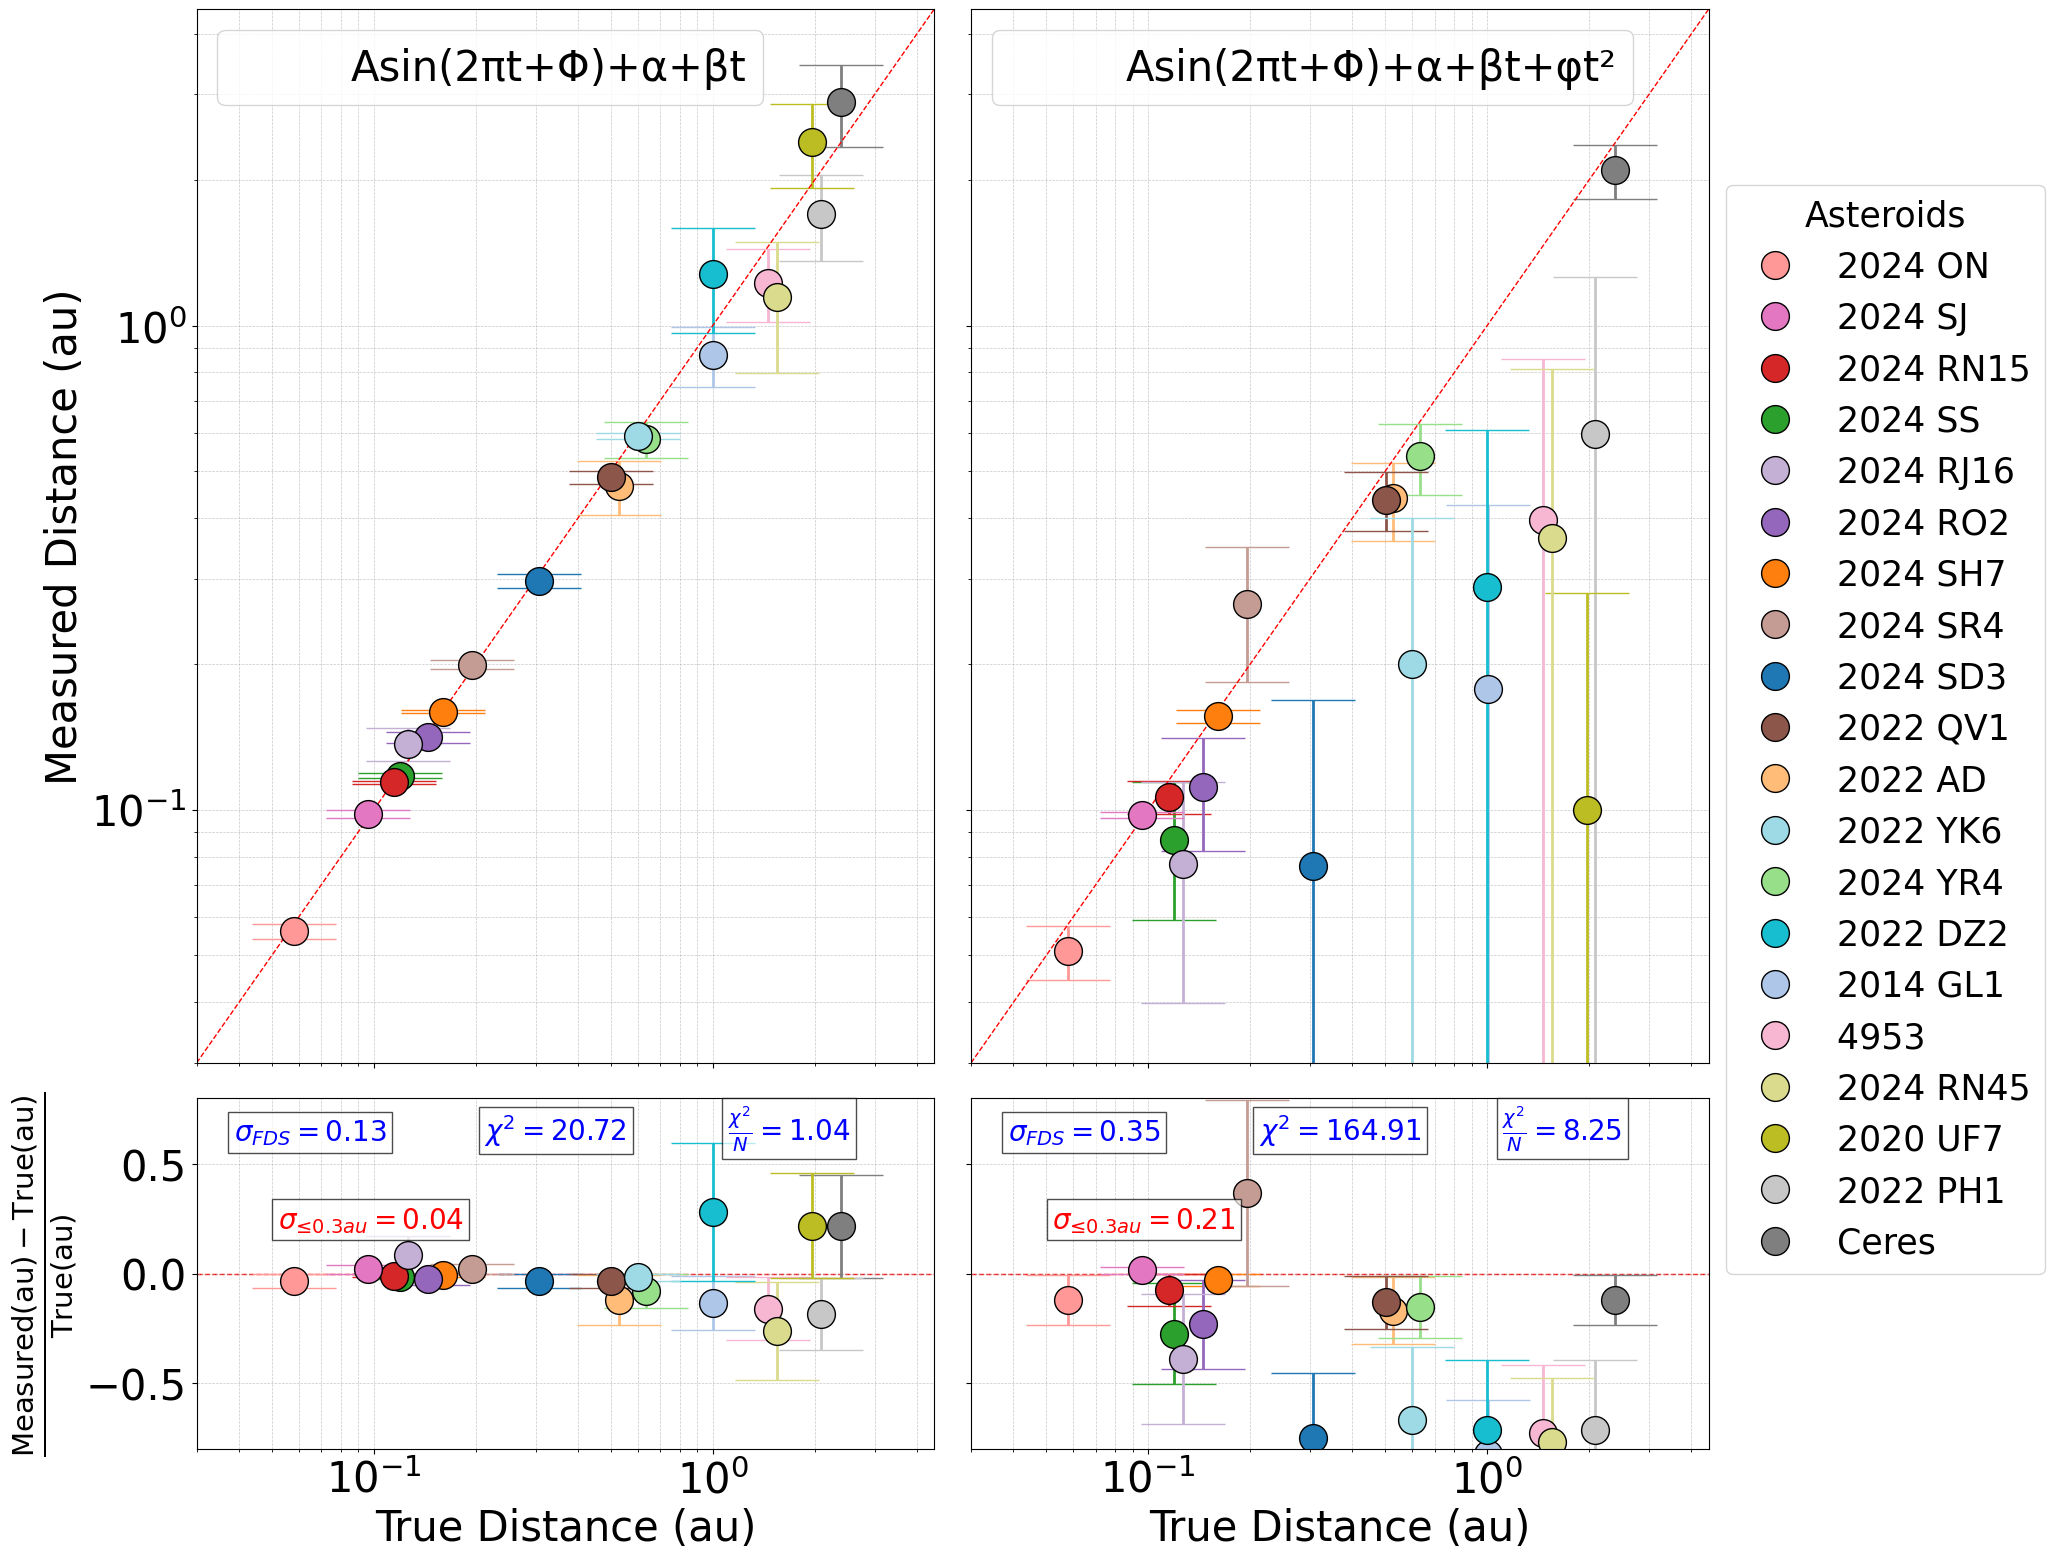

In [27]:
fig = plt.figure(figsize=(18, 18))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3, 1])
colors = plt.cm.tab20(np.linspace(0, 1, len(results_df)))

# Top-left: Linear fit
ax1 = plt.subplot(gs[0, 0])
for i, color in enumerate(colors):
    ax1.errorbar(
        true_values.iloc[i], cosine_term_lin_values.iloc[i], yerr=uncertainty_cosine_lin.iloc[i], fmt='o',
        color=color, markersize=20, markeredgecolor='black', capsize=30, linewidth=2)
ax1.plot([0.03, 4.5], [0.03, 4.5], 'r--', linewidth=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.03, 4.5)
ax1.set_ylim(0.03, 4.5)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_ylabel('Measured Distance (au)', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.set_xticklabels([])
ax1.legend([Line2D([0], [0], color='w', lw=0)], ['Asin(2πt+Φ)+α+βt'], loc='upper left', fontsize=30)

# Top-right: Polynomial fit
ax2 = plt.subplot(gs[0, 1])
for i, color in enumerate(colors):
    ax2.errorbar(
        true_values.iloc[i], cosine_term_poly_values.iloc[i], yerr=uncertainty_cosine_poly.iloc[i], fmt='o',
        color=color, markersize=20, markeredgecolor='black', capsize=30, linewidth=2)
ax2.plot([0.03, 4.5], [0.03, 4.5], 'r--', linewidth=1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.03, 4.5)
ax2.set_ylim(0.03, 4.5)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.legend([Line2D([0], [0], color='w', lw=0)], ['Asin(2πt+Φ)+α+βt+φt²'], loc='upper left', fontsize=30)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Bottom-left: Residuals for Linear fit
ax3 = plt.subplot(gs[1, 0])
for i, color in enumerate(colors):
    ax3.errorbar(
        true_values.iloc[i], residuals_lin.iloc[i], yerr=residuals_uncertainty_lin.iloc[i], fmt='o',
        color=color, markersize=20, markeredgecolor='black', capsize=30, linewidth=2)
ax3.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)
ax3.text(0.05, 0.88, f"$\\sigma_{{FDS}} = {sigma_lin:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.11, 0.63, f"$\\sigma_{{≤0.3au}} = {std_dev_residuals_below_03:.2f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.39, 0.88, f"$\\chi^2 = {chi2_lin:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.72, 0.88, f"$\\frac{{\\chi^2}}{{N}} = {red_chi2_lin:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax3.transAxes)
ax3.set_xlim(0.03, 4.5)
ax3.set_xscale('log')
ax3.set_ylim(-0.8, 0.8)
ax3.set_yscale('linear')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax3.set_ylabel(r'$\frac{\mathrm{Measured (au)} - \mathrm{True (au)}}{\mathrm{True (au)}}$', fontsize=30)
ax3.set_xlabel('True Distance (au)', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# Bottom-right: Residuals for Polynomial fit
ax4 = plt.subplot(gs[1, 1])
for i, color in enumerate(colors):
    ax4.errorbar(
        true_values.iloc[i], residuals_poly.iloc[i], yerr=residuals_uncertainty_poly.iloc[i], fmt='o',
        color=color, markersize=20, markeredgecolor='black', capsize=30, linewidth=2)
ax4.axhline(0, color='red', linestyle='--', linewidth=1, zorder=1)
ax4.text(0.05, 0.88, f"$\\sigma_{{FDS}} = {sigma_poly:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)
ax4.text(0.11, 0.63, f"$\\sigma_{{≤0.3au}} = {std_dev_residuals_below_03_poly:.2f}$", fontsize=20, color='red',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)
ax4.text(0.39, 0.88, f"$\\chi^2 = {chi2_poly:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)
ax4.text(0.72, 0.88, f"$\\frac{{\\chi^2}}{{N}} = {red_chi2_poly:.2f}$", fontsize=20, color='blue',
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), transform=ax4.transAxes)
ax4.set_xlim(0.03, 4.5)
ax4.set_xscale('log')
ax4.set_ylim(-0.8, 0.8)
ax4.set_yscale('linear')
ax4.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax4.set_xlabel('True Distance (au)', fontsize=30)
ax4.set_yticklabels([])
ax4.tick_params(axis='both', which='major', labelsize=30)

# Sorting Asteroid distance in legend
if isinstance(true_values, pd.Series):
    results_df['Mean Delta'] = true_values
else:
    results_df['Mean Delta'] = true_values.mean(axis=1)

sorted_indices = results_df['Mean Delta'].values.argsort()
sorted_file_names = results_df['File Name'].iloc[sorted_indices]
sorted_deltas = results_df['Mean Delta'].iloc[sorted_indices]
colors = np.array(colors)
sorted_colors = colors[sorted_indices]

max_name_length = max(len(file_name.replace('.csv', '')) for file_name in sorted_file_names)
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
           markeredgecolor='black', markersize=20,
           label=f"{file_name.replace('.csv', '').ljust(max_name_length)}")
    for file_name, delta, color in zip(sorted_file_names, sorted_deltas, sorted_colors)
]

fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=25,
           title="Asteroids", title_fontsize=25, frameon=True)

plt.subplots_adjust(left=0.01, right=0.85, top=0.9, bottom=0.1, wspace=0.05, hspace=0.05)
plt.savefig("Figure 3.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

##### Summary: 

##### 1) This notebook processes single-night Horizons data for 20 asteroids so as to measure their distances using the topocentric-parallax method as seen in Eqs. 1 and 5 in the mauscript. 

##### 2) For each asteroid, we fit both the linear and quadratic parallax models, compare the recovered distances to the true Horizons distances, and compute residuals, percentage errors, and χ² statistics. 

##### 3) The linear parallax model consistently yields a reduced χ² close to ~1, showing that it accurately captures the parallax signal for short arcs. The quadratic model produces larger χ² values, indicating unnecessary complexity. 

##### 4) Overall, the results demonstrate that a simple linear topocentric-parallax fit is robust and reliable for short observational windows.